In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# modules
import datetime
import glob
import xarray as xr
from netCDF4 import Dataset
import scipy.io as sio
import time
import matplotlib.gridspec as gridspec

import sys
#import dask
import seaborn

# Loading the data:

* HYCOM25

In [3]:
!ncdump -h /Users/laura/Documents/PhD_stuff/Project_Brian/HYCOM25/SPW/HYCOM25_ssh_SPW_2014_day_066_hour_00.nc

netcdf HYCOM25_ssh_SPW_2014_day_066_hour_00 {
dimensions:
	y = 276 ;
	x = 426 ;
variables:
	double Fssh(x, y) ;
		Fssh:_FillValue = -9999. ;
		Fssh:units = "m" ;
		Fssh:missing_value = -9999. ;
		Fssh:long_name = "Full SSH" ;
	double Sssh(x, y) ;
		Sssh:_FillValue = -9999. ;
		Sssh:units = "cm" ;
		Sssh:missing_value = -9999. ;
		Sssh:long_name = "Steric SSH" ;

// global attributes:
		:filename = "HYCOM25_ssh_SPW_2014_day_066_hour_00.nc" ;
		:creation_date = "22-Jan-2019 22:03:55" ;
		:description = "HYCOM 25 South Pacific West Ocean Data coverted from binary file to netcdf file." ;
}


In [4]:
dir_model_n = '/Users/laura/Documents/PhD_stuff/Project_Brian/HYCOM25/SPW/'
#ssh_files_root = dir_model + 'HYCOM25_ssh_SPW_reg_2014_day_'

input_filename_n = 'HYCOM25_ssh_SPW_2014_day_'
#HYCOM25_ssh_wmed_2014_day_195_hour_09.nc

In [5]:
myfiles_n = sorted(glob.glob(dir_model_n + input_filename_n + '*.nc'))


In [6]:
myfiles_n[0]

'/Users/laura/Documents/PhD_stuff/Project_Brian/HYCOM25/SPW/HYCOM25_ssh_SPW_2014_day_001_hour_01.nc'

In [36]:
ssh_files_n = sorted(glob.glob(dir_model_n + input_filename_n + '*.nc'))


# Select only FMA files:

In [56]:
np.int(ssh_files_n[0][-14:-11]) < 32

True

In [60]:
ssh_files_n_FMA2 = [s for s in ssh_files_n if np.int(s[-14:-11]) > 31]
ssh_files_n_FMA = [s for s in ssh_files_n_FMA2 if np.int(s[-14:-11]) < 122]

# Plot and select subregion:

In [64]:
ds_o_n = xr.open_dataset(ssh_files_n_FMA[0])#, engine='h5netcdf')
ssh_n = ds_o_n.Fssh


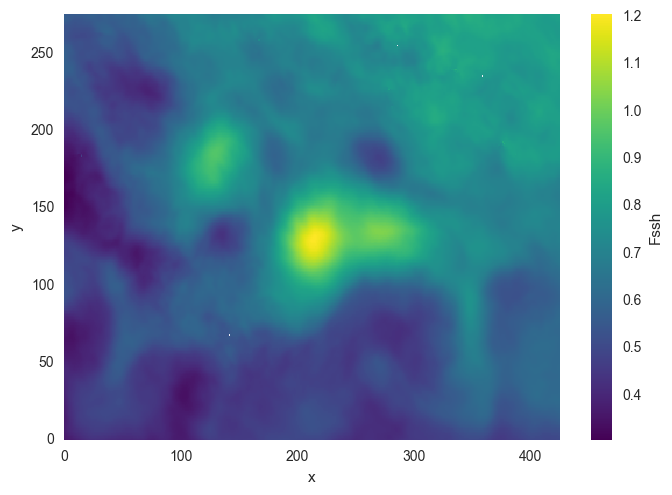

In [65]:
ssh_n.T.plot()#(vmax=0.)

In [66]:
ssh_n.shape

(426, 276)

# Need to subselect SQAURE box, with no land:
(data needs to be too in lon, lat shape)

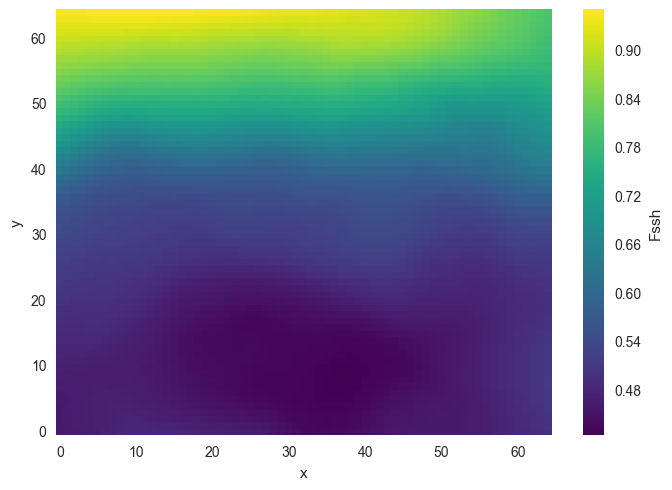

In [67]:
ssh_n[250:315,60:125].T.plot()

# Import lon, lat:

In [68]:
!ncdump -h /Users/laura/Documents/PhD_stuff/Project_Brian/HYCOM25/SPW/HYCOM25_spw_navlon_navlat.nc

netcdf HYCOM25_spw_navlon_navlat {
dimensions:
	y = 276 ;
	x = 426 ;
variables:
	double nav_lon(x, y) ;
	double nav_lat(x, y) ;

// global attributes:
		:filename = "HYCOM25_spw_navlon_navlat.nc" ;
		:creation_date = "26-Jan-2019 12:57:36" ;
		:description = "HYCOM25 data grid coverted from .mat file to netcdf file." ;
}


In [69]:
ds_o_n_c = xr.open_dataset('/Users/laura/Documents/PhD_stuff/Project_Brian/HYCOM25/SPW/HYCOM25_spw_navlon_navlat.nc')
lon_n = ds_o_n_c.nav_lon
lat_n = ds_o_n_c.nav_lat

In [70]:
print lat_n.shape
print lon_n.shape

(426, 276)
(426, 276)


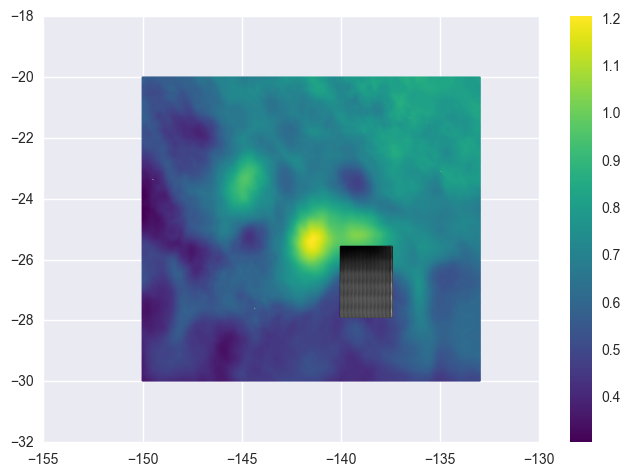

In [71]:
plt.scatter(lon_n, lat_n, s=2, c=ssh_n,  cmap='viridis', linewidths=0);plt.colorbar()
plt.scatter(lon_n[250:315,60:125], lat_n[250:315,60:125], s=2, c=ssh_n[250:315,60:125])

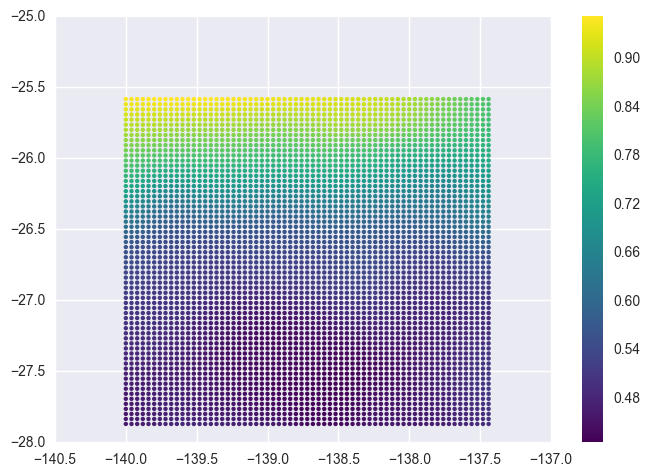

In [72]:
plt.scatter(lon_n[250:315,60:125], lat_n[250:315,60:125], s=10, c=ssh_n[250:315,60:125], cmap='viridis', linewidths=0); plt.colorbar()

In [73]:
((1./25)*110) * 65 # boz is about 286 x 286 km

286.0

In [74]:
lon_box = lon_n[250:315,60:125].to_masked_array()
lat_box = lat_n[250:315,60:125].to_masked_array()

### Box limits in lon, lat:


In [75]:
print 'lon min:'
print np.unique(lon_box[0,:].data)[0]
print 'lon max:'
print np.unique(lon_box[-1,:].data)[0]
print 'lat min:'
print np.unique(lat_box[:,0].data)[0]
print 'lat max:'
print np.unique(lat_box[:,-1].data)[0]

lon min:
-140.0
lon max:
-137.440002441
lat min:
-27.8709869385
lat max:
-25.5847454071


In [76]:
adt_box = ssh_n[250:315,60:125].to_masked_array()

# Spectra

In [77]:
sys.path.insert(0, "/Users/laura/src/git/PowerSpec-master/")
#import OpenDataSet as op
import PowerSpec_old as ps


In [78]:
lon_box.shape

(65, 65)

In [79]:
m2km = 1.E3

# all hourly files FMA:

In [80]:
for ii in xrange(0, len(ssh_files_n_FMA)):
        
    ds_o = xr.open_dataset(ssh_files_n_FMA[ii])#, engine='h5netcdf')
    
    adt_box = ds_o.Fssh[250:315,60:125]

    x, y, data = ps.interpolate(adt_box, lon_box, lat_box, interp='basemap')
    # - check if data contains nan. If yes,replace with interpolated values.
    ##data = ps.isdata_contain_nan(data)
    # - compute sepctrum
    kstep_ssh_N, pspec_ssh_N = ps.get_spectrum(data, x, y, window='tukey', detrend='both')

    if ii==0:
        pspec_ssh_Nt = np.empty([len(pspec_ssh_N), len(ssh_files_n_FMA)])
    pspec_ssh_Nt[:, ii] = pspec_ssh_N


In [81]:
pspec_ssh_Nt.shape

(21, 2160)

In [82]:
pspec_ssh_Nt.mean(axis=1).shape

(21,)

# Plot mean of FMA:

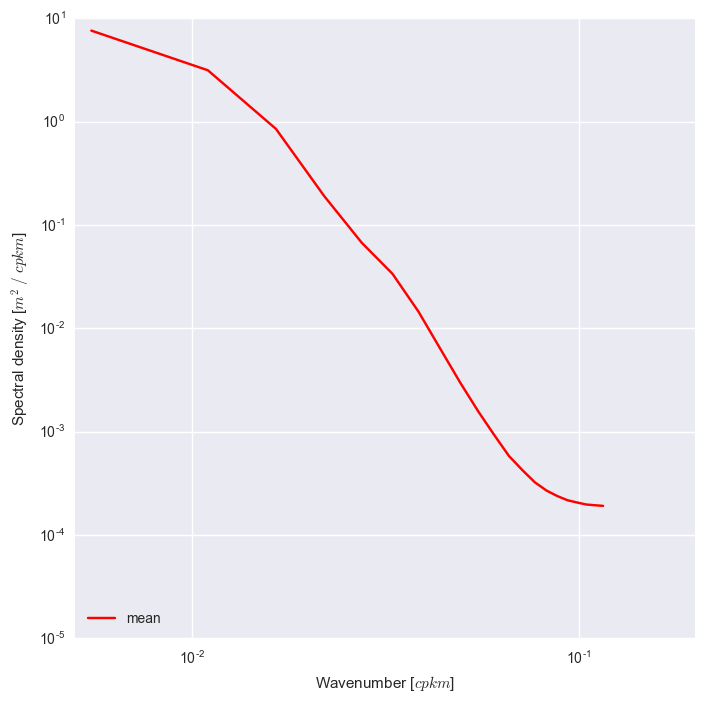

In [83]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.loglog(kstep_ssh_N * m2km, pspec_ssh_Nt.mean(axis=1), 'r', label='mean')
ax.grid(True)
ax.set_ylim([1e-5, 1e1])
ax.set_xlim([5e-3, .2])
ax.legend(loc='lower left')
ax.set_xlabel('Wavenumber [$cpkm$]')
ax.set_ylabel('Spectral density [$m$$^2$ $/$ $cpkm$]')

